# Data story

Disposition
0. Bakgrund
    - Syftet är att i den här Data Storyn ta reda om om det är fördelaktigt för Guldfynd att investera i diamantförsäljning som ett komplement till övrig försäljning av ädelmetaller. 
1. Kort om städningen av datasetet
    - Statistisk städning där jag tar bort extremvärden och nollvärden.
    - Test av förhållandet mellan carat och ytvärdena x, y och z för att se hur carat förhåller sig till dessa, vilket visade att ca hälften var felberäknad. 
    - Tar bort x, y och z, eftersom dessa inte tillför något längre utifrån syftet
    - Encode kategorier
    - Normaliserar datan för att kunna göra jämförelser, bl. a. korrelation.
    - Dela upp datasetet i korrekta och inkorrekta beräkningar och fortsätter jobba med korrekta beräkningar.
2. Vad påverkar priset?
    - Om man kollar på hela datasetet och korrelation mellan pris och övriga features har carat enskild påverkan på priset, vilket känns orimligt.
    - scatterplot som visar spridningen av carat och pris
    - dela upp carat i grupper för att se korrelation beroende på storleken, vilket visar att i de storlekar som är vanligast i försäljning (kolla upp källa) påverkar carat minst.
    - feature-påverkan för att förtydliga hur mycket depth, table, cut, color, clarity påverkar inom de olika carat-grupperna.


## Vad behöver jag kolla?
- Påverkan på pris utifrån dataset A, B och C - generell
    - Korrelansplot i varje dataset utifrån de tio grupperna.
    - Jämförelse av de tre dataseten i förhållande till feature-analys
- Påverkan på pris utifrån carat-grupper

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

df_correct_carat_clean = pd.read_csv('../data/normalized_diamonds_clean_corr_carat_without_x_y_z.csv', index_col=0)
df_incorrect_carat_clean = pd.read_csv('../data/normalized_diamonds_clean_inc_carat_without_x_y_z.csv', index_col=0)
df_original_clean = pd.read_csv('../data/normalized_diamonds_clean_without_x_y_z.csv', index_col=0)

### Korrelation

#### df_correct_carat_clean

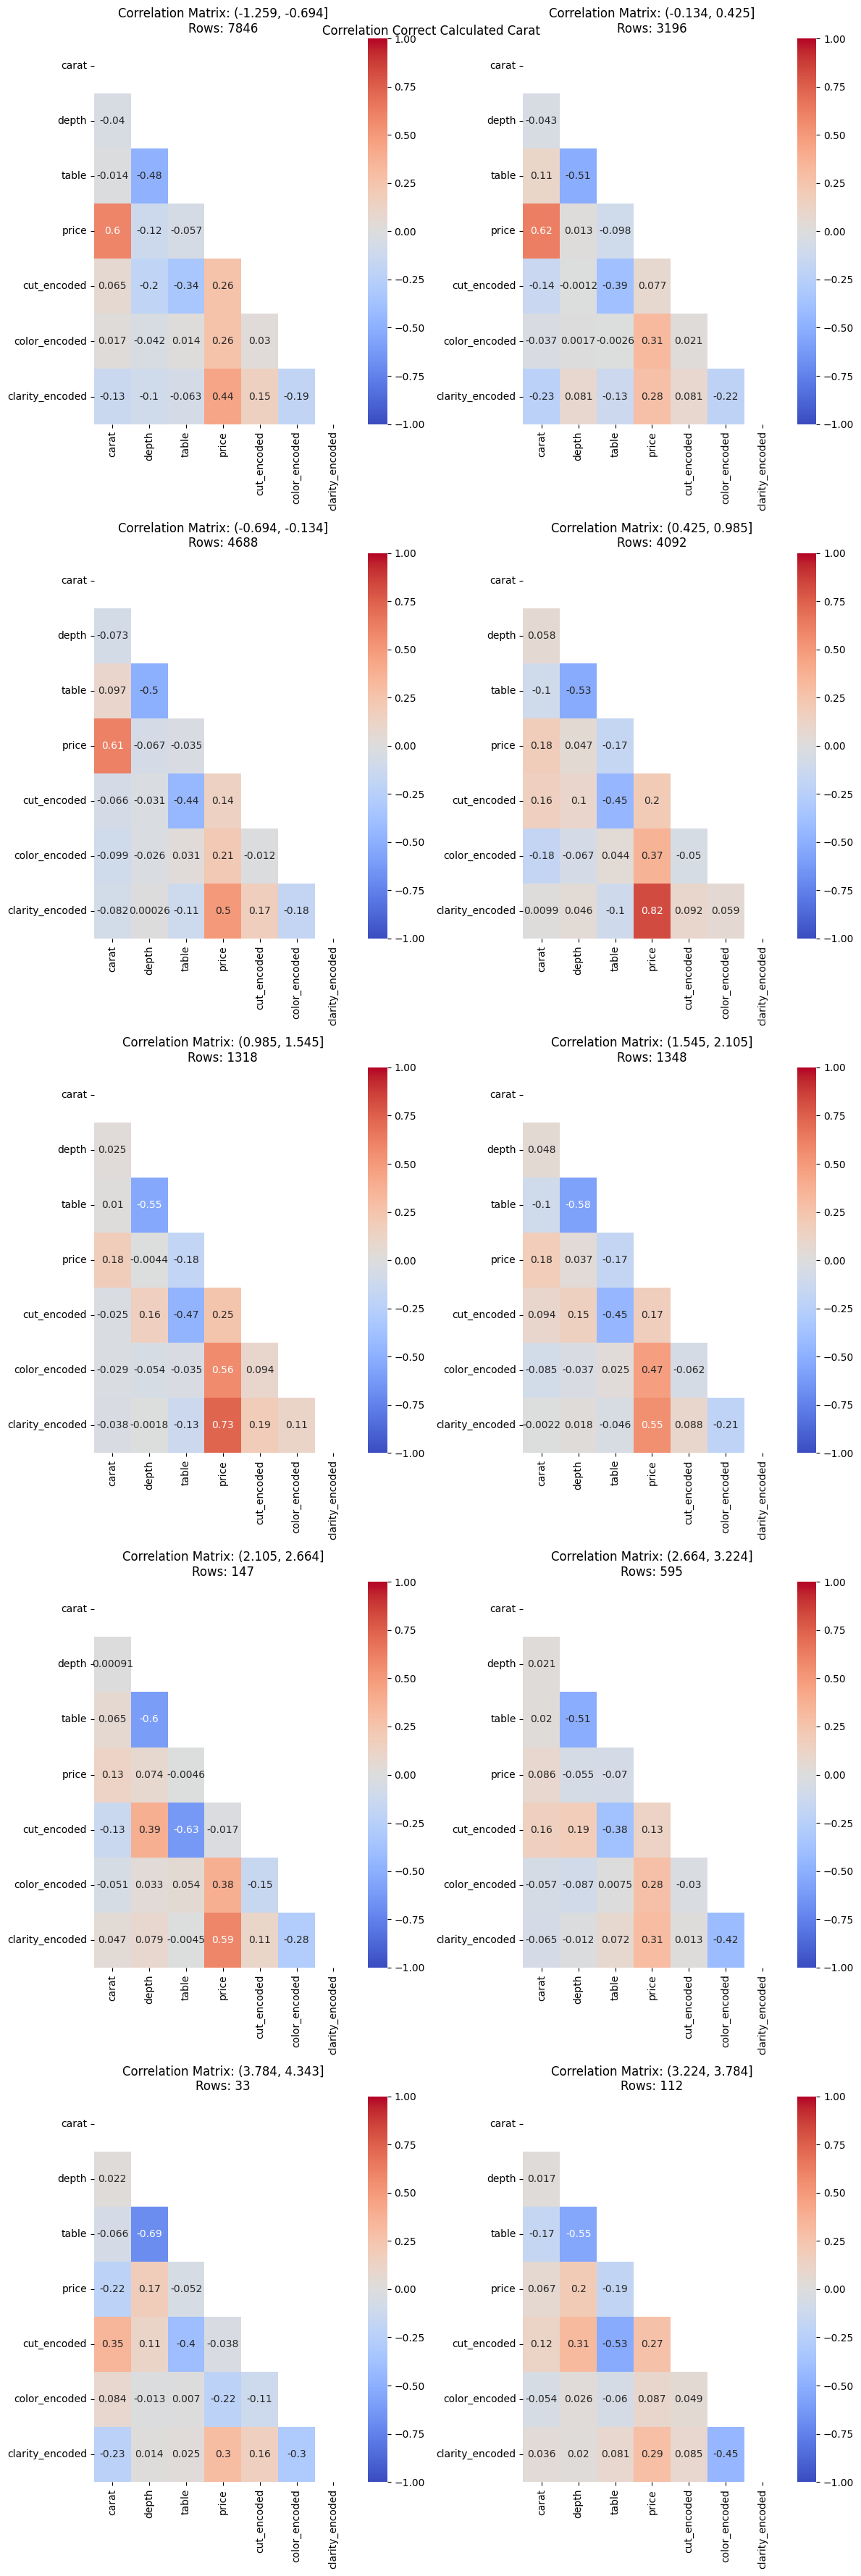

In [4]:
df_correct_carat_clean['carat_bins'] = pd.cut(df_correct_carat_clean.carat, bins=10)

carat_bin = df_correct_carat_clean['carat_bins'].unique()
f, axs = plt.subplots(5, 2, figsize=(12, 36))

for i, category in enumerate(carat_bin):
    subset = df_correct_carat_clean[df_correct_carat_clean['carat_bins'] == category]
    count = len(subset)
    correlation = subset.select_dtypes(include=['number']).corr()
    ax = axs.flat[i]
    mask = np.triu(correlation)
    sns.heatmap( correlation, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f"Correlation Matrix: {category}\nRows: {count}")

plt.suptitle("Correlation Correct Calculated Carat")
plt.tight_layout()
plt.show()

##### Summering
Korrelationen mellan pris och carat, clarity, color och cut förändras väsentligt beroende på vilken caratgrupp. Vilket betyder att fokus för försäljning behöver ha olika fokus beroende på vilken caratgrupp som är aktuell. I de två grupper som kan antas vara de som oftare säljs (0.98-1.24, 1.24-1-5 och 1.5-1.76) är clarity, color och cut mer avgörande än själva storleken.

#### incorrect_carat_clean

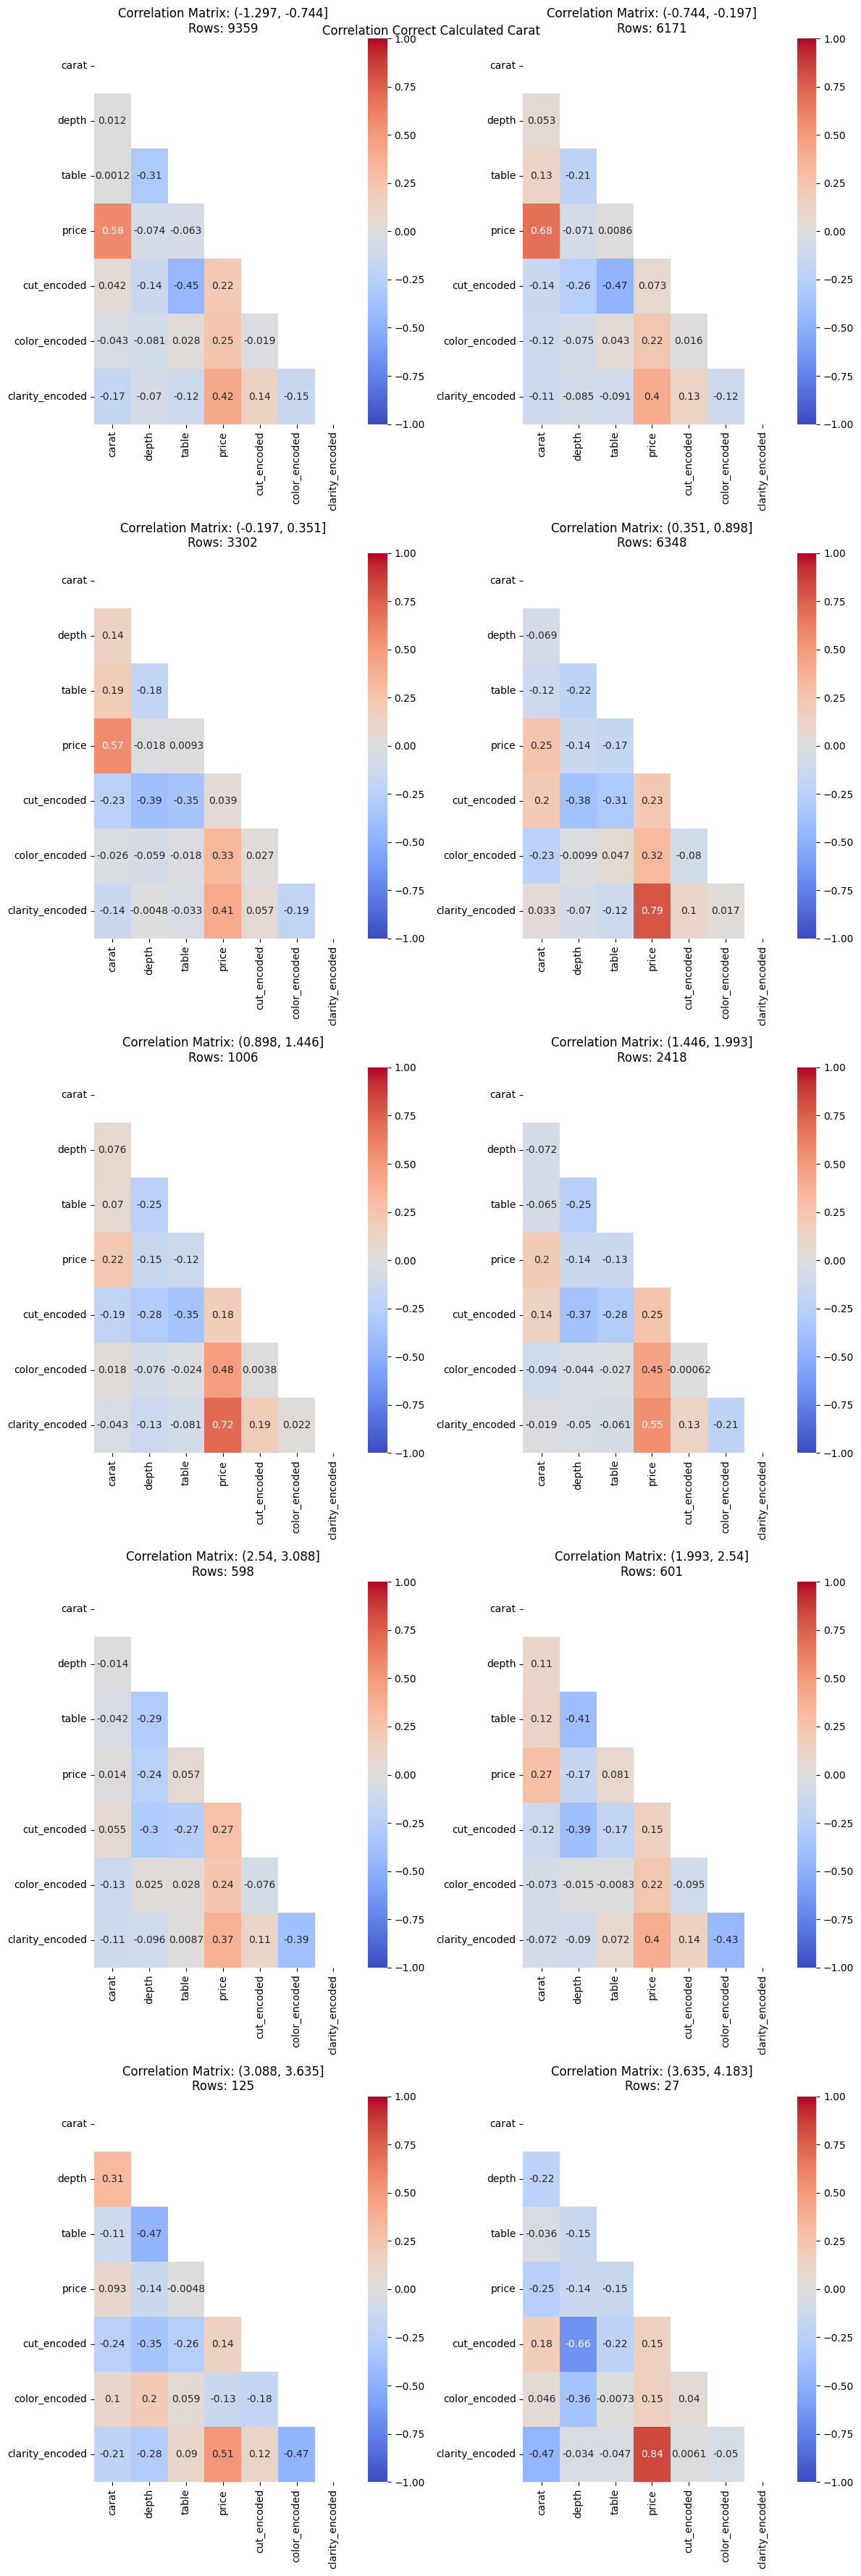

In [6]:
df_incorrect_carat_clean['carat_bins'] = pd.cut(df_incorrect_carat_clean.carat, bins=10)

carat_bin = df_incorrect_carat_clean['carat_bins'].unique()
f, axs = plt.subplots(5, 2, figsize=(12, 36))

for i, category in enumerate(carat_bin):
    subset = df_incorrect_carat_clean[df_incorrect_carat_clean['carat_bins'] == category]
    count = len(subset)
    correlation = subset.select_dtypes(include=['number']).corr()
    ax = axs.flat[i]
    mask = np.triu(correlation)
    sns.heatmap( correlation, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f"Correlation Matrix: {category}\nRows: {count}")

plt.suptitle("Correlation Correct Calculated Carat")
plt.tight_layout()
plt.show()

##### Summering
Följer liknande mönster

#### df_original_clean

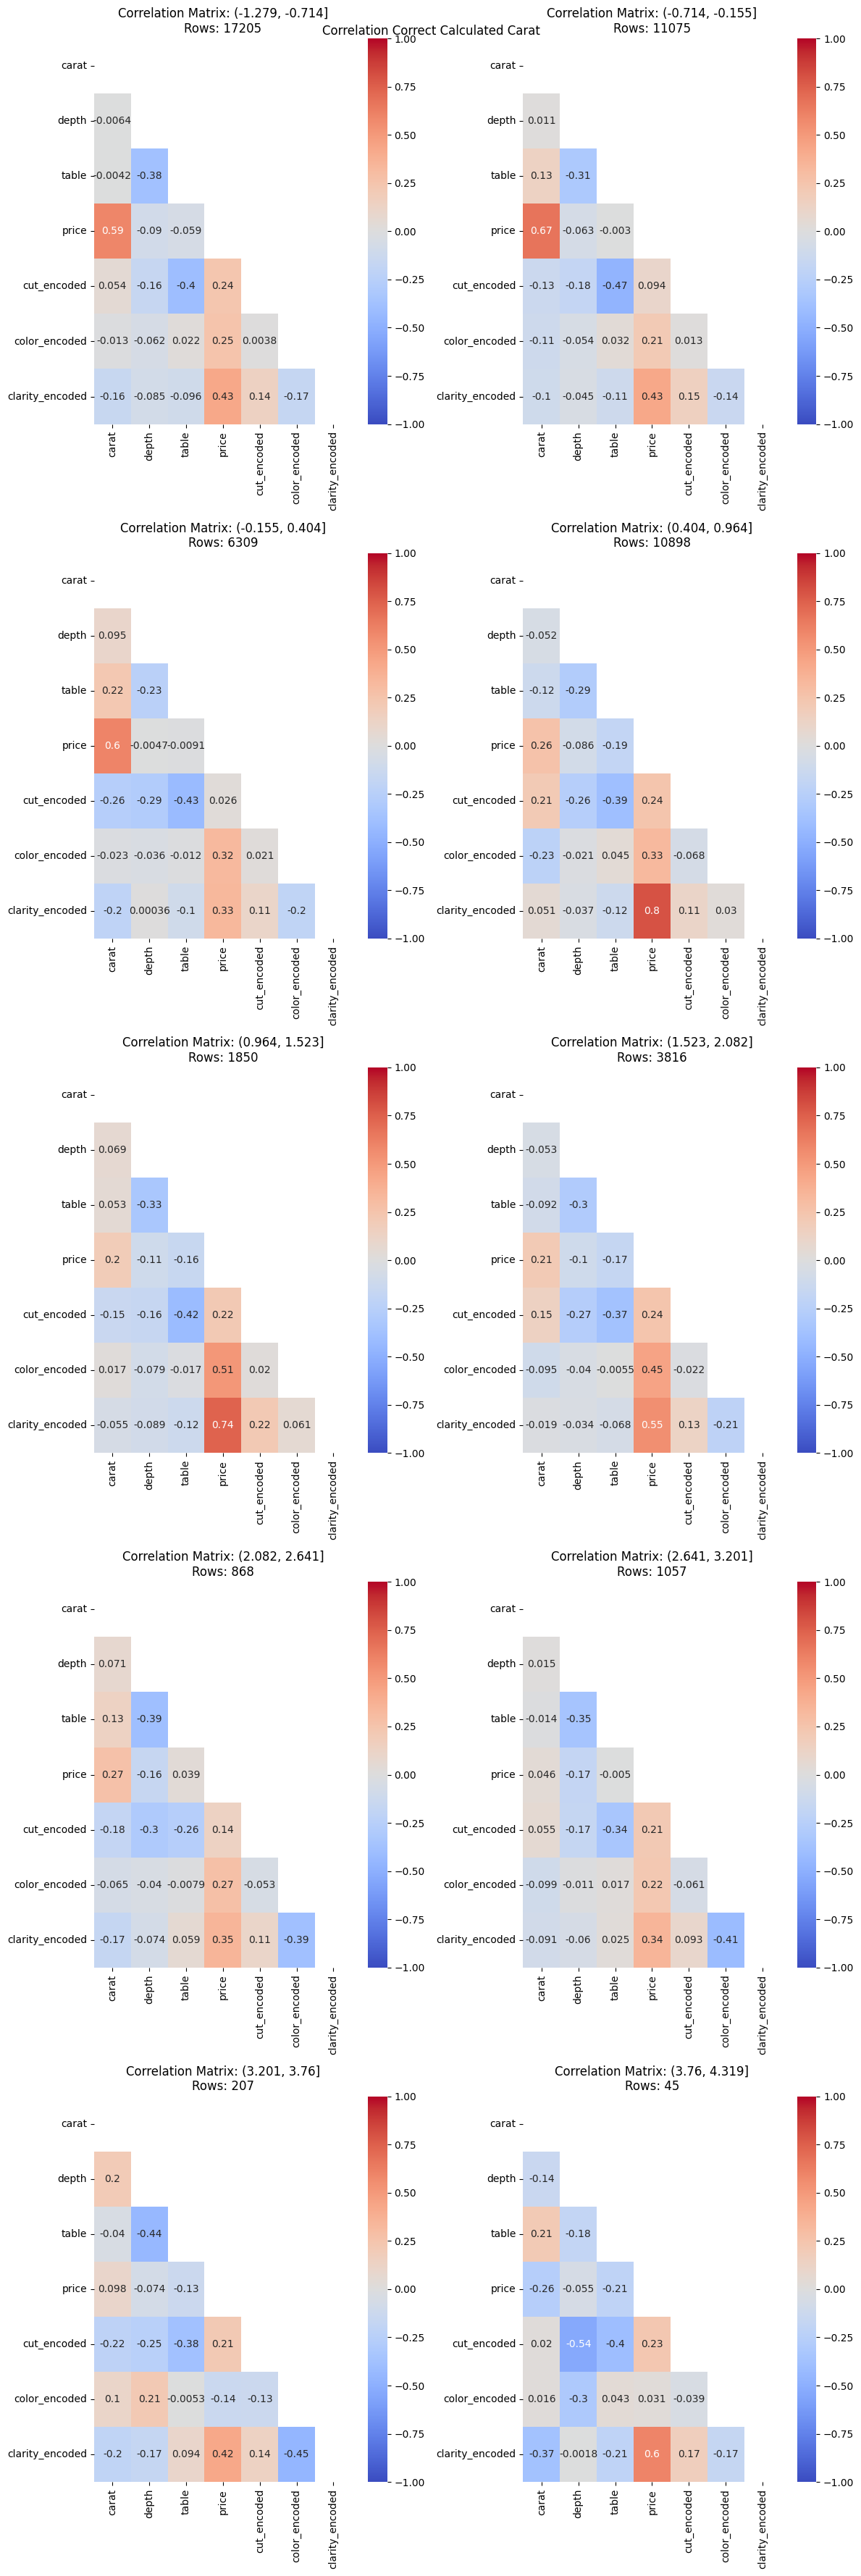

In [7]:
df_original_clean['carat_bins'] = pd.cut(df_original_clean.carat, bins=10)
carat_bin = df_original_clean['carat_bins'].unique()
f, axs = plt.subplots(5, 2, figsize=(12, 36))

for i, category in enumerate(carat_bin):
    subset = df_original_clean[df_original_clean['carat_bins'] == category]
    count = len(subset)
    correlation = subset.select_dtypes(include=['number']).corr()
    ax = axs.flat[i]
    mask = np.triu(correlation)
    sns.heatmap( correlation, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f"Correlation Matrix: {category}\nRows: {count}")

plt.suptitle("Correlation Correct Calculated Carat")
plt.tight_layout()
plt.show()

##### Summering
Följer liknande mönster

### Carat bins i jämförelse mellan varandra inom respektive dataset

#### df_correct_carat_clean

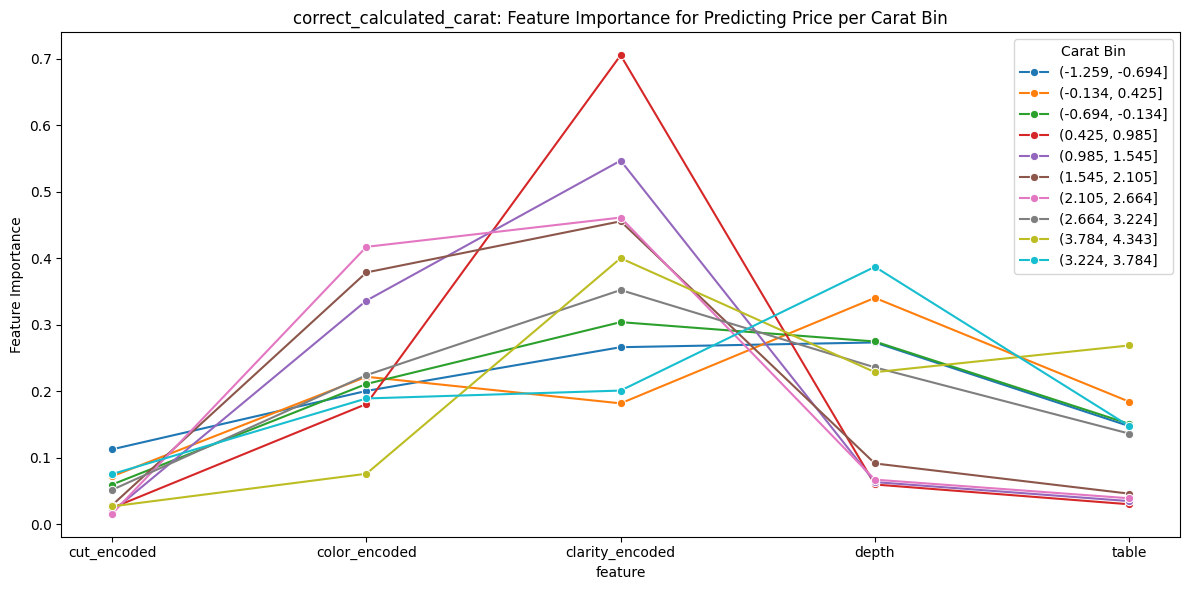

In [8]:
features = ['cut_encoded', 'color_encoded', 'clarity_encoded', 'depth', 'table']
bins = df_correct_carat_clean['carat_bins'].unique()
importance_per_bin = {}

for bin in bins:
    subset = df_correct_carat_clean[df_correct_carat_clean['carat_bins'] == bin]
    X = subset[features]
    y = subset['price']
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importance_per_bin[bin] = model.feature_importances_
    
importance_df = pd.DataFrame(importance_per_bin, index=features)

importance_long = importance_df.T.reset_index().melt(id_vars='index')
importance_long.columns = ['carat_bin', 'feature', 'importance']

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=importance_long,
    x='feature',
    y='importance',
    hue='carat_bin',
    marker='o'
)
plt.ylabel('Feature Importance')
plt.title('correct_calculated_carat: Feature Importance for Predicting Price per Carat Bin')
plt.legend(title='Carat Bin')
plt.tight_layout()
plt.show()


##### Summering
För den vanligaste sålda storleken runt 1 carat spelar clarity en väldigt stor roll

#### incorrect_calculated_carat

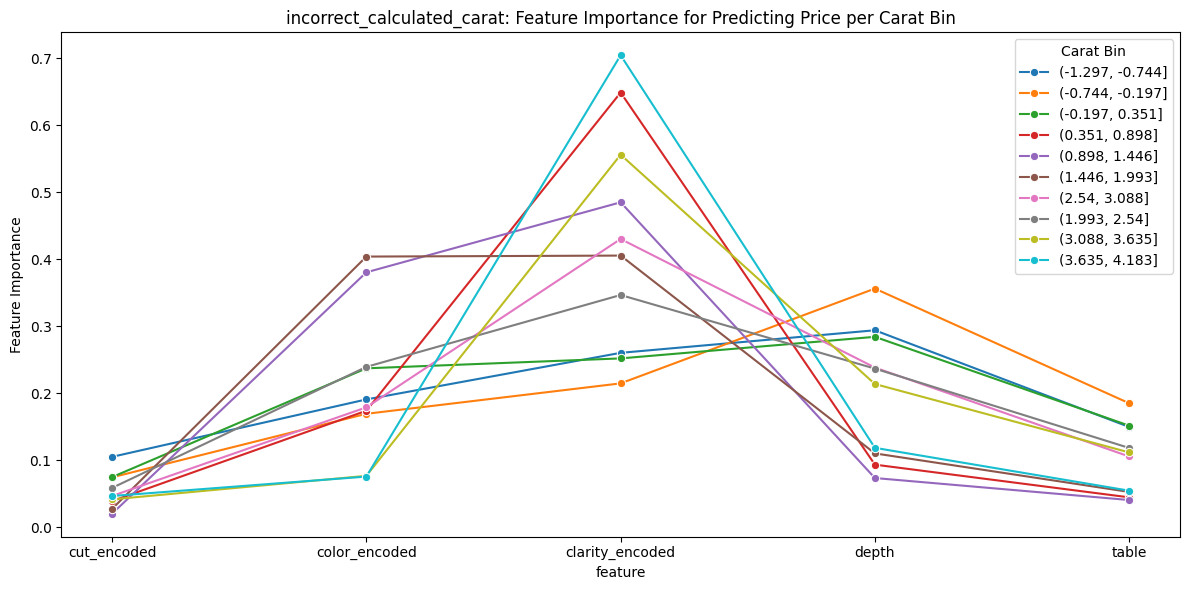

In [9]:
features = ['cut_encoded', 'color_encoded', 'clarity_encoded', 'depth', 'table']
bins = df_incorrect_carat_clean['carat_bins'].unique()
importance_per_bin = {}

for bin in bins:
    subset = df_incorrect_carat_clean[df_incorrect_carat_clean['carat_bins'] == bin]
    X = subset[features]
    y = subset['price']
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importance_per_bin[bin] = model.feature_importances_
    
importance_df = pd.DataFrame(importance_per_bin, index=features)

importance_long = importance_df.T.reset_index().melt(id_vars='index')
importance_long.columns = ['carat_bin', 'feature', 'importance']

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=importance_long,
    x='feature',
    y='importance',
    hue='carat_bin',
    marker='o'
)
plt.ylabel('Feature Importance')
plt.title('incorrect_calculated_carat: Feature Importance for Predicting Price per Carat Bin')
plt.legend(title='Carat Bin')
plt.tight_layout()
plt.show()

#### original

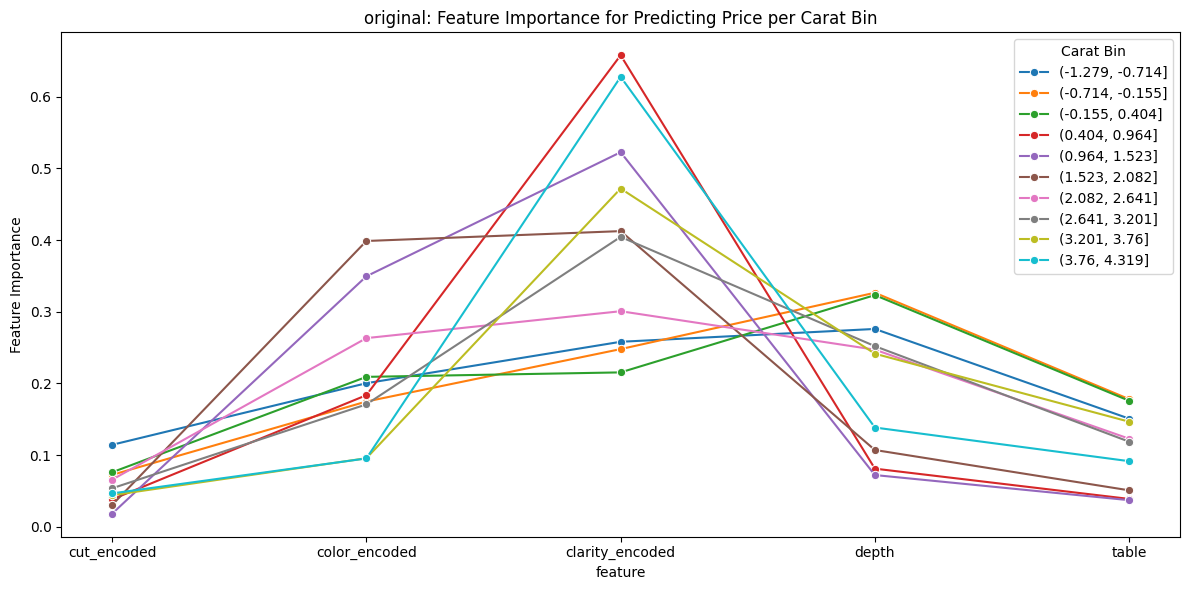

In [10]:
features = ['cut_encoded', 'color_encoded', 'clarity_encoded', 'depth', 'table']
bins = df_original_clean['carat_bins'].unique()
importance_per_bin = {}

for bin in bins:
    subset = df_original_clean[df_original_clean['carat_bins'] == bin]
    X = subset[features]
    y = subset['price']
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importance_per_bin[bin] = model.feature_importances_
    
importance_df = pd.DataFrame(importance_per_bin, index=features)

importance_long = importance_df.T.reset_index().melt(id_vars='index')
importance_long.columns = ['carat_bin', 'feature', 'importance']

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=importance_long,
    x='feature',
    y='importance',
    hue='carat_bin',
    marker='o'
)
plt.ylabel('Feature Importance')
plt.title('original: Feature Importance for Predicting Price per Carat Bin')
plt.legend(title='Carat Bin')
plt.tight_layout()
plt.show()